In [1]:
import pandas          as pd
import numpy           as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook           import tqdm 
from joblib                  import Parallel, delayed
from matplotlib_venn         import venn2, venn3
from sklearn.decomposition   import PCA
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



# functions ###############################################################################################
def run_anova(gene, df, formula):
    gene_df =df[df['gene']==gene]
    
    lm = ols(formula, data=gene_df).fit()
    table = sm.stats.anova_lm(lm, typ=2) 
    
    age_C = lm.params['C(timepoint)[T.mid]']
    
    layer_F = table['F']['C(tissue)']
    region_F = table['F']['C(cortical_region)']
    age_F = table['F']['C(timepoint)']
    
    layer_eta2 = table['sum_sq']['C(tissue)'] / (table['sum_sq'].sum())
    region_eta2 = table['sum_sq']['C(cortical_region)'] / (table['sum_sq'].sum())
    age_eta2 = table['sum_sq']['C(timepoint)'] / (table['sum_sq'].sum())
    
    layer_logp = -np.log(table['PR(>F)']['C(tissue)'])
    region_logp = -np.log(table['PR(>F)']['C(cortical_region)'])
    age_logp = -np.log(table['PR(>F)']['C(timepoint)'])
    
    return [gene, age_C, layer_F, region_F, age_F, layer_eta2, region_eta2, age_eta2, layer_logp, region_logp, age_logp]




# dictionaries ###############################################################################3
# tissue zone names
tissue_dict = {'cortical_plate':'0.cortical_plate',
               'subplate': '1.subplate',
               'intermediate': '2.intermediate',
               'subventricular': '3.subventricular',
               'ventricular': '4.ventricular'}
# specimen ages
specimen_age_dict = {'H376.IIIA.02':15, 'H376.IIIB.02':16, 'H376.IV.02':21, 'H376.IV.03':21}

# specimen timepoints
specimen_timepoint_dict = {'H376.IIIA.02':'early', 'H376.IIIB.02':'early', 'H376.IV.02':'mid', 'H376.IV.03':'mid'}







# formatting ####################################################################################
specimen_palette = ['#631A86', '#C45AB3', '#F45866', '#ff939c']
tissue_palette = ['#7AE582','#21D375',  '#25A18E', '#00A5CF', '#004E64']

# default fontsize
FNT = 20



FDR_VAL = 0.01



# locations ####################################################################################
# location of preprocessed microarray data
microarray_data_path = 'XXX/MicroarrayData/'

# location to save outputs
output_dir = 'OUTPUTS/'
results_dir = 'RESULTS/'


In [3]:
# LOAD DATA ###################################################################################################
microarray_data = pd.read_csv('{:}/final_data.csv'.format(microarray_data_path))
microarray_data['tissue'] = microarray_data['tissue'].map(tissue_dict)



# SET UP FOR PCA ##############################################################################################
# gene x (specimen, region, tissue) matrix
microarray_data_for_pca = microarray_data.pivot_table(values='expression', index=['gene'] , columns=['cortical_region', 'tissue', 'specimen_id']).T
microarray_data_for_pca = microarray_data_for_pca.reset_index()

# remove genes with more than 10% missing samples
nan_genes = (pd.isna(microarray_data_for_pca).sum(0) / len(microarray_data_for_pca)) < .1
print('removing {:} genes with >10% missing samples'.format(len(nan_genes)-sum(nan_genes)))
print('{:} genes remaining'.format(sum(nan_genes)))
print('')
microarray_data_for_pca = microarray_data_for_pca.loc[:,nan_genes]
keep_genes = list(microarray_data_for_pca.drop(['cortical_region', 'tissue', 'specimen_id'], axis=1).columns)

# replace remaining NaN with average gene expression for pca
microarray_data_for_pca = microarray_data_for_pca.fillna(microarray_data_for_pca.mean(axis=0), axis=0)

# demeaned expression data
microarray_data_for_pca.iloc[:,3:] = microarray_data_for_pca - microarray_data_for_pca.mean(0)






# PCA ##########################################################################################################
# apply PCA to ALL data 
print('performing initial PCAs')
full_pca = PCA(n_components=2)
full_pca.fit(microarray_data_for_pca.iloc[:,3:])
full_pca_components = full_pca.transform(microarray_data_for_pca.iloc[:,3:])

# apply PCA to each specimen separately
specimen_name = []
specimen_data = []
specimen_model = []
specimen_components = []
specimen_age = []
for n, specimen in enumerate(sorted(microarray_data_for_pca['specimen_id'].unique())):
    specimen_data.append(microarray_data_for_pca[microarray_data_for_pca['specimen_id']==specimen])
    specimen_name.append(specimen)
    specimen_model.append(PCA(n_components=2))
    specimen_age.append(specimen_age_dict[specimen])
    specimen_model[n].fit(specimen_data[n].iloc[:,3:])
    specimen_components.append(specimen_model[n].transform(specimen_data[n].iloc[:,3:]))
    print(specimen_name[n])

# apply PCA to each tissue type separately
print('')
tissue_name = []
tissue_data = []
tissue_model = []
tissue_components = []
for n, tissue in enumerate(microarray_data_for_pca['tissue'].unique()):
    tissue_data.append(microarray_data_for_pca[microarray_data_for_pca['tissue']==tissue])
    tissue_name.append(tissue)
    tissue_model.append(PCA(n_components=2))
    
    tissue_model[n].fit(tissue_data[n].iloc[:,3:])
    tissue_components.append(tissue_model[n].transform(tissue_data[n].iloc[:,3:]))
    print(tissue_name[n])

removing 1253 genes with >10% missing samples
8774 genes remaining

performing initial PCAs
H376.IIIA.02
H376.IIIB.02
H376.IV.02
H376.IV.03

0.cortical_plate
1.subplate
2.intermediate
3.subventricular
4.ventricular


## PCA plots



see /data/gareth.ball/micro-brain/ANALYSIS/RESULTS//microarray-PCA.png
see /data/gareth.ball/micro-brain/ANALYSIS/RESULTS//microarray-PCA-per-specimen.png
see /data/gareth.ball/micro-brain/ANALYSIS/RESULTS//tissue-PCA-loadings-cross-correlations.png
/data/gareth.ball/micro-brain/ANALYSIS/OUTPUTS//PCA-gene-loadings-0.cortical_plate.csv
/data/gareth.ball/micro-brain/ANALYSIS/OUTPUTS//PCA-gene-loadings-1.subplate.csv
/data/gareth.ball/micro-brain/ANALYSIS/OUTPUTS//PCA-gene-loadings-2.intermediate.csv
/data/gareth.ball/micro-brain/ANALYSIS/OUTPUTS//PCA-gene-loadings-3.subventricular.csv
/data/gareth.ball/micro-brain/ANALYSIS/OUTPUTS//PCA-gene-loadings-4.ventricular.csv


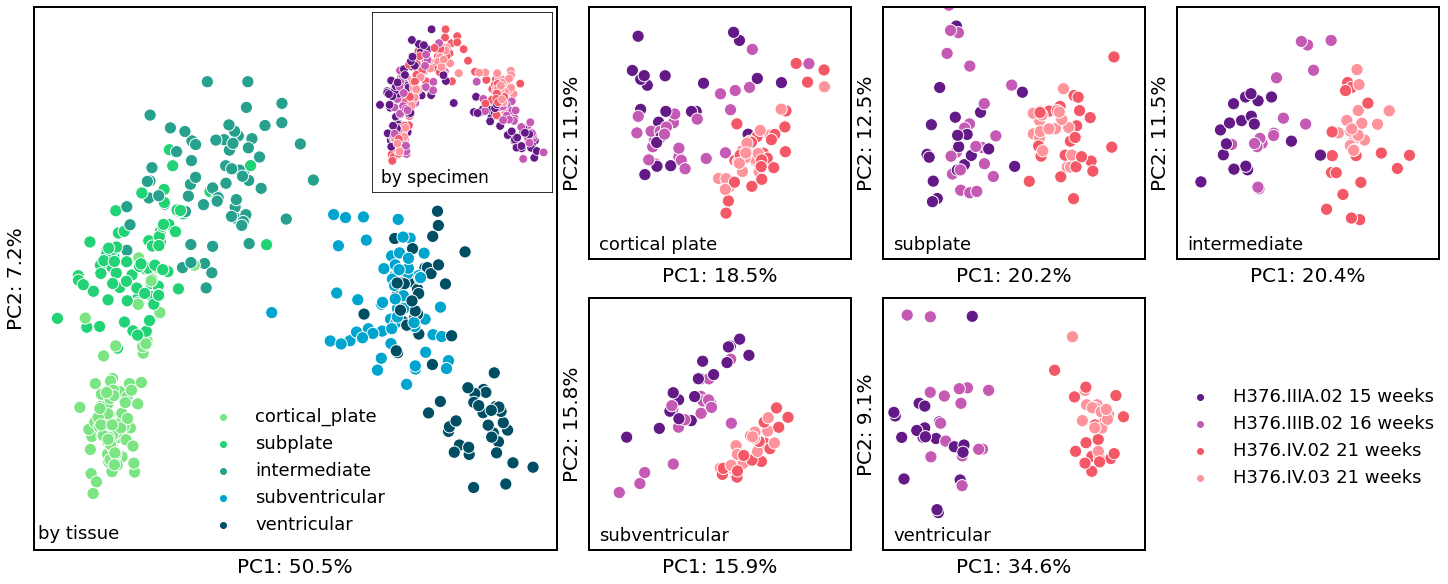

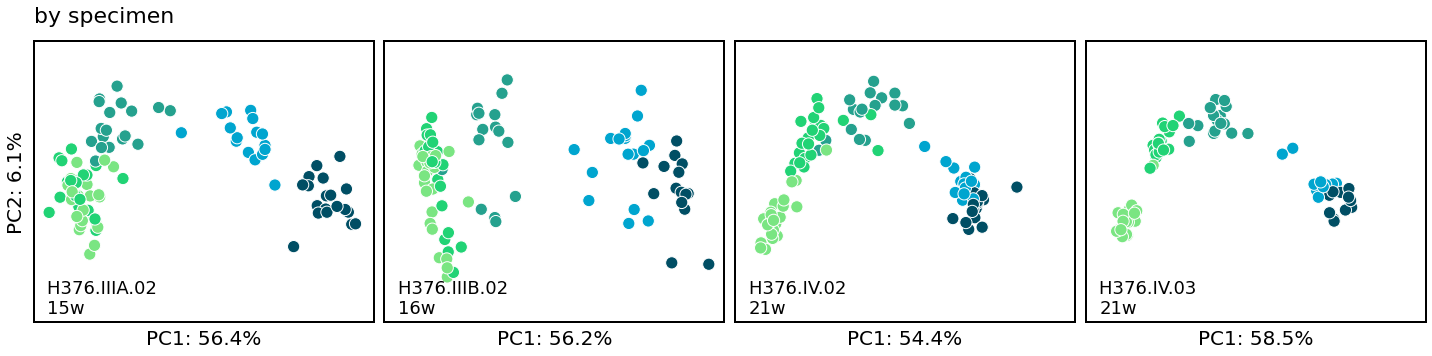

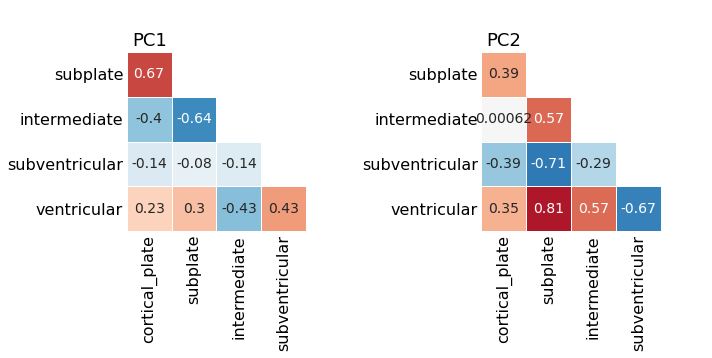

In [4]:
# subplot configuration
axd = plt.figure(constrained_layout=True, figsize=(20,8)).subplot_mosaic("""AABCD
                                                                            AAEFG""")



# Full PCA ######################################################################################################
sns.scatterplot(x=full_pca_components[:,0], y=full_pca_components[:,1], 
                hue=microarray_data_for_pca['tissue'], 
                s=150,
                palette=tissue_palette, 
                ax=axd['A'])
axd['A'].set_ylim(-60, 75)
axd['A'].set_xlabel('PC1: {:.1f}%'.format(full_pca.explained_variance_ratio_[0]*100), fontsize=FNT)
axd['A'].set_ylabel('PC2: {:.1f}%'.format(full_pca.explained_variance_ratio_[1]*100), fontsize=FNT)
axd['A'].text(-95,-57, 'by tissue', fontsize=FNT-2)

for spine in axd['A'].spines.values():
    spine.set_linewidth(2)

# inset plot coloured by specimen
axins = inset_axes(axd['A'], width=2.5, height=2.5)
sns.scatterplot(x=full_pca_components[:,0], y=full_pca_components[:,1], 
                hue=microarray_data_for_pca['specimen_id'], 
                hue_order = sorted(microarray_data_for_pca['specimen_id'].unique()),
                s=75,
                palette=specimen_palette, 
                ax=axins, legend=False)
for axi in [axins]:
    axi.tick_params(which='both', length=0)
    axi.set_xticklabels('')
    axi.set_yticklabels('')
    axi.set_ylim(-70, 70)
    axi.text(-85,-63, 'by specimen', fontsize=FNT-3)

# legend
hand, lab = axd['A'].get_legend_handles_labels()
axd['A'].legend(handles=hand, labels=[t.split('.')[1] for t in lab], loc="lower center", fontsize=FNT-2, frameon=False)  
   
    
    
    
    
# Tissue specific plots #########################################################################################
for n, p in  enumerate(['B','C','D','E','F']):
    if (p=='D') or (p=='E') or (p=='F'):
        # flip PC1 to match others
        sns.scatterplot(x=-tissue_components[n][:,0], y=tissue_components[n][:,1], 
            hue=tissue_data[n].reset_index()['specimen_id'], 
            hue_order = sorted(microarray_data_for_pca['specimen_id'].unique()),
            palette=specimen_palette, 
            s=150,
            ax=axd[p], legend=False)
    else:
        sns.scatterplot(x=tissue_components[n][:,0], y=tissue_components[n][:,1], 
                    hue=tissue_data[n].reset_index()['specimen_id'], 
                    hue_order = sorted(microarray_data_for_pca['specimen_id'].unique()),
                    palette=specimen_palette, 
                    s=150,
                    ax=axd[p], legend=False)
    axd[p].text(-60,-60, tissue_name[n].split('.')[1].replace('_',' '), fontsize=FNT-2)
    axd[p].set_xlim(-65,65)
    axd[p].set_ylim(-65,65)
    axd[p].set_xlabel('PC1: {:.1f}%'.format(tissue_model[n].explained_variance_ratio_[0]*100), fontsize=FNT)
    axd[p].set_ylabel('PC2: {:.1f}%'.format(tissue_model[n].explained_variance_ratio_[1]*100), fontsize=FNT)
    for spine in axd[p].spines.values():
        spine.set_linewidth(2)

        
        
        
        
# Extras ########################################################################################################
# dummy plot for legend
sns.scatterplot(x=tissue_components[4][:,0], y=tissue_components[4][:,1], 
                hue=tissue_data[4].reset_index()['specimen_id'], 
                hue_order = sorted(microarray_data_for_pca['specimen_id'].unique()),
                palette=specimen_palette, 
                s=0,
                ax=axd['G'])
axd['G'].legend(labels=[''] + ['{:} {:} weeks'.format(s, specimen_age_dict[s]) for s in specimen_name], loc="center", fontsize=FNT-2, frameon=False)    
for spine in axd['G'].spines.values():
    spine.set_linewidth(0)

# remove ticks
for a in axd:
    axd[a].tick_params(which='both', length=0)
    axd[a].set_xticklabels('')
    axd[a].set_yticklabels('')

print('see {:}/microarray-PCA.png'.format(results_dir))
plt.savefig('{:}/microarray-PCA.png'.format(results_dir), dpi=300, transparent=False, facecolor='white')







# PLOT EACH PCA FROM EACH BRAIN #############################################################################
# by specimen
fig, ax = plt.subplots(1,4, figsize=(20, 5), sharex=True, sharey=True)
for n,a in enumerate(ax):
    if specimen_name[n] == 'H376.IIIB.02': # flip PC2 to match the others
            sns.scatterplot(x=specimen_components[n][:,0], y=-specimen_components[n][:,1], 
                hue=specimen_data[n]['tissue'], 
                hue_order=sorted(microarray_data_for_pca['tissue'].unique()),
                s=150,
                palette=tissue_palette, 
                ax=a, legend=False)
    else:    
        sns.scatterplot(x=specimen_components[n][:,0], y=specimen_components[n][:,1], 
                    hue=specimen_data[n]['tissue'], 
                    hue_order=sorted(microarray_data_for_pca['tissue'].unique()),
                    s=150,
                    palette=tissue_palette, 
                    ax=a, legend=False)
    a.text(-85, -85, '{:} \n{:}w'.format(specimen_name[n], specimen_age[n]), fontsize=FNT-2)
    a.tick_params(which='both', length=0)
    a.set_xticklabels('')
    a.set_yticklabels('')
    a.set_ylim(-90,80)
    a.set_xlabel('PC1: {:.1f}%'.format(specimen_model[n].explained_variance_ratio_[0]*100), fontsize=FNT)
    a.set_ylabel('PC2: {:.1f}%'.format(specimen_model[n].explained_variance_ratio_[1]*100), fontsize=FNT)
    for spine in a.spines.values():
        spine.set_linewidth(2)
        
fig.suptitle('by specimen', x=0.075, fontsize=FNT+2)
plt.tight_layout()

print('see {:}/microarray-PCA-per-specimen.png'.format(results_dir))
plt.savefig('{:}/microarray-PCA-per-specimen.png'.format(results_dir), dpi=300, transparent=False, facecolor='white')


# PC loadings across zones #####################################################################################
fig, ax = plt.subplots(1,2,figsize=(10,5))
for npc, pc in enumerate(['PC1', 'PC2']):
    loadings_df = pd.DataFrame(np.array([tissue_model[n].components_[npc,:] for n in np.arange(5)]).T)
    loadings_df.columns = [t.split('.')[1] for t in tissue_name]

    corr = loadings_df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='RdBu_r', vmax=1, vmin=-1,center=0, annot=True,
                square=True, linewidths=.5, cbar=False, 
                xticklabels=[t.split('.')[1] for t in tissue_name][:-1],
                yticklabels=[''] + [t.split('.')[1] for t in tissue_name][1:],
                annot_kws = {'fontsize':FNT-6}, ax=ax[npc])

    ax[npc].set_title(pc, fontsize=FNT-2, x=0.1, y=0.8)
    ax[npc].tick_params(which='both', length=0, labelsize=FNT-4)
plt.tight_layout()
print('see {:}/tissue-PCA-loadings-cross-correlations.png'.format(results_dir))
plt.savefig('{:}/tissue-PCA-loadings-cross-correlations.png'.format(results_dir), dpi=300, transparent=False, facecolor='white')

# save out PC weights for each gene
for n in np.arange(5):
    comp_df = pd.DataFrame((list(microarray_data_for_pca.columns[3:]), tissue_model[n].components_[0], tissue_model[n].components_[1])).T
    comp_df.columns = ['gene', 'PC1', 'PC2']
    print('{:}/PCA-gene-loadings-{:}.csv'.format(output_dir, tissue_name[n]))
    comp_df.to_csv('{:}/PCA-gene-loadings-{:}.csv'.format(output_dir, tissue_name[n]), index=None)

# Effects of age, region and tissue zone
As an initial filter, we identify genes with expression that varies by ZONE, REGION or TIMEPOINT. By fitting an ANOVA for each gene with main effects of tissue zone, cortical region and time point ('early' vs 'mid'). ZONE, REGION and TIMEPOINT genes are identified as those with a significant main effect of each factor, with FDR correction for multiple comparisons. 

In [ ]:
# RUN GENE MODELS ################################################################################################
# add timepoint for each specimen
microarray_data['timepoint'] = microarray_data['specimen_id'].map(specimen_timepoint_dict)
# keep only genes without lots of NaNs
microarray_data = microarray_data[microarray_data['gene'].isin(keep_genes)]
# save out
print('see {:}/microarray-data-for-ANOVA.csv'.format(output_dir))
microarray_data.to_csv('{:}/microarray-data-for-ANOVA.csv'.format(output_dir), index=None)

# statsmodel works in parallel(?) so just run this on 1 cpu at a time
aov_results = Parallel(n_jobs=1)(
                   delayed(run_anova)(g, microarray_data, 'expression ~ C(cortical_region) + C(tissue) + C(timepoint)') for g in tqdm(sorted(microarray_data['gene'].unique())))




# Results ########################################################################################################
aov_results = pd.DataFrame(np.stack(aov_results))
aov_results.columns = ['gene', 'C_age', 'F_layer','F_region','F_age', 'eta2_layer', 'eta2_region', 'eta2_age', 'logp_layer', 'logp_region', 'logp_age' ]
aov_results[aov_results.columns[1:]] = aov_results[aov_results.columns[1:]].apply(pd.to_numeric)

# save out 
print('see: {:}/all-genes-ANOVA-results.csv'.format(output_dir))
aov_results.to_csv('{:}/all-genes-ANOVA-results.csv'.format(output_dir), index=None)

ZONE genes: 
8761 (99.89%) significant
see /data/gareth.ball/micro-brain/ANALYSIS/OUTPUTS//ZONE-genes-anova-results.csv

REGION genes: 
5585 (63.68%) significant
see /data/gareth.ball/micro-brain/ANALYSIS/OUTPUTS//REGION-genes-anova-results.csv

TIMEPOINT genes: 
3302 (37.65%) significant
see /data/gareth.ball/micro-brain/ANALYSIS/OUTPUTS//TIMEPOINT-genes-anova-results.csv

2145 genes with significant main effects of ZONE, REGION and TIMEPOINT on expression
5575 genes with significant main effects of ZONE and REGION on expression


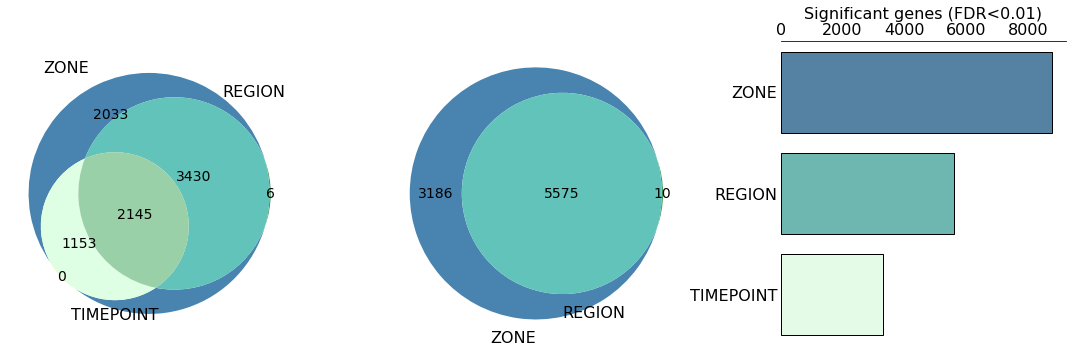

In [6]:
# Identify genes that var by tissue zone, region or layer ########################################################
# select genes based on FDR-corrected main effects (Benjamini-Yekutieli for dependent tests) 
aov_results = pd.read_csv('{:}/all-genes-ANOVA-results.csv'.format(output_dir))

for p, eff in zip(['logp_layer', 'logp_region', 'logp_age'], ['ZONE', 'REGION', 'TIMEPOINT']):
    # select genes based on FDR
    sig_genes = fdrcorrection(np.exp(-aov_results[p].astype(float)), alpha=FDR_VAL)[0]
    gene_result = aov_results[sig_genes]
    # save out
    print('{:} genes: '.format(eff))
    print('{:} ({:.2f}%) significant'.format(len(gene_result), 100*(len(gene_result)/len(aov_results))))
    print('see {:}/{:}-genes-anova-results.csv'.format(output_dir, eff))
    print('')
    gene_result.to_csv('{:}/{:}-genes-anova-results.csv'.format(output_dir, eff), index=None)


# load significant gene lists    
ZONE_genes = pd.read_csv('{:}/ZONE-genes-anova-results.csv'.format(output_dir))
REGION_genes = pd.read_csv('{:}/REGION-genes-anova-results.csv'.format(output_dir))
TIMEPOINT_genes = pd.read_csv('{:}/TIMEPOINT-genes-anova-results.csv'.format(output_dir))

ZRT_genes = sorted(list(set(ZONE_genes['gene']) & set(REGION_genes['gene']) & set(TIMEPOINT_genes['gene'])))
print('{:} genes with significant main effects of ZONE, REGION and TIMEPOINT on expression'.format(len(ZRT_genes)))
np.savetxt('{:}/all-ZRT-genes.txt'.format(results_dir), ZRT_genes, fmt='%s')
np.savetxt('{:}/all-microarray-genes.txt'.format(results_dir), aov_results['gene'].values, fmt='%s')

ZR_genes = sorted(list(set(ZONE_genes['gene']) & set(REGION_genes['gene'])))
print('{:} genes with significant main effects of ZONE and REGION on expression'.format(len(ZR_genes)))
np.savetxt('{:}/all-ZR-genes.txt'.format(results_dir), ZR_genes, fmt='%s')





# PLOTS ###################################################################################################
fig, ax = plt.subplots(1,3,figsize=(15,5))
# ZRT genes
v3=venn3(subsets=[set(ZONE_genes['gene']), set(REGION_genes['gene']), set(TIMEPOINT_genes['gene'])],
      set_labels=['ZONE', 'REGION', 'TIMEPOINT'],normalize_to=1,
      set_colors=['#4884af', '#44935b', '#f6f197'], alpha=1, ax=ax[0])
for text in v3.set_labels:
    text.set_fontsize(FNT-4)
for text in v3.subset_labels:
    if text:
        text.set_fontsize(FNT-6)
        
#RT genes        
v2=venn2(subsets=[set(ZONE_genes['gene']), set(REGION_genes['gene'])],
      set_labels=['ZONE', 'REGION'], normalize_to=2.0,
      set_colors=['#4884af', '#44935b'], alpha=1, ax=ax[1])
for text in v2.set_labels:
    text.set_fontsize(FNT-4)
for text in v2.subset_labels:
    if text:
        text.set_fontsize(FNT-6)

# number of genes
sns.barplot(y=['ZONE', 'REGION', 'TIMEPOINT'], x=[len(ZONE_genes), len(REGION_genes), len(TIMEPOINT_genes)],
            ax=ax[2], orient='h', palette=['#4884af', '#62c3ba', '#dfffe4'], edgecolor='black')
ax[2].set_xlabel('Significant genes (FDR<0.01)', fontsize=FNT-4)
ax[2].tick_params(which='both', length=0, labelsize=FNT-4)
ax[2].xaxis.tick_top()
ax[2].xaxis.set_label_position('top') 
sns.despine(top=False, ax=ax[2], bottom=True, left=True)


#sns.despine(left=True)
plt.tight_layout()
plt.savefig('{:}/ZRT-genes-overlap.png'.format(results_dir), dpi=300, transparent=False, facecolor='white')


/group/deve2/data/gareth.ball/brainAtlas/pix2pix_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/group/deve2/data/gareth.ball/brainAtlas/pix2pix_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


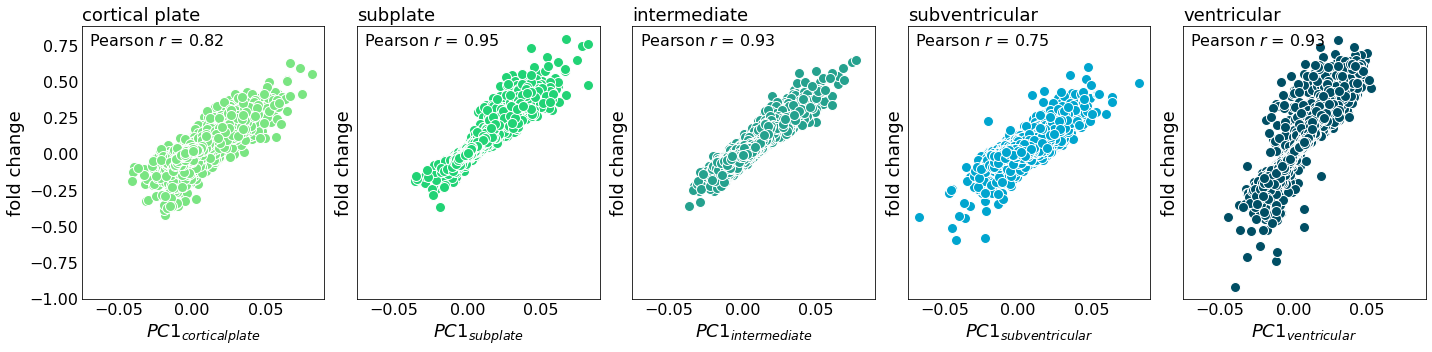

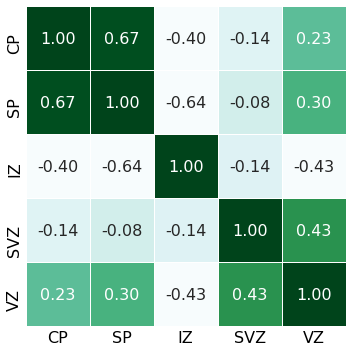

In [8]:
# Correlation between PC1 and differential expression in each tissue zone
reverse_tissue_dict = dict(zip(tissue_dict.values(), tissue_dict.keys()))

all_pc_data = []
fig, ax = plt.subplots(1, 5, figsize=(20, 5), sharey=True, sharex=True)
for n, zone in  enumerate(['0.cortical_plate', '1.subplate', '2.intermediate', '3.subventricular', '4.ventricular']):

    # average gene expression over regions
    plot_data = microarray_data[microarray_data['tissue']==zone].drop('DS', axis='columns').groupby(by=['timepoint', 'gene']).mean().reset_index()

    # diff expression
    early_data = plot_data[plot_data['timepoint']=='early']
    mid_data = plot_data[plot_data['timepoint']=='mid']

    # difference between mid and early
    early_data['diff'] = np.log2(mid_data['expression'].values) - np.log2(early_data['expression'].values)

    # load PC data
    pc_data = pd.read_csv('OUTPUTS/PCA-gene-loadings-{:}.csv'.format(zone))
    all_pc_data.append(pc_data)

    early_data['PC1'] = early_data['gene'].map(dict(zip(pc_data['gene'], pc_data['PC1'])))

    if n >1:
        ax[n].scatter(-early_data['PC1'], early_data['diff'], c=tissue_palette[n], edgecolor='white', s=100)
    else:
        ax[n].scatter(early_data['PC1'], early_data['diff'], c=tissue_palette[n], edgecolor='white', s=100)
    
    ax[n].set_title(reverse_tissue_dict[zone].replace('_', ' '), fontsize=18, loc='left')
    ax[n].tick_params('both', length=0, labelsize=16)
    ax[n].set_xlabel('$PC1_{{ {:} }}$'.format(reverse_tissue_dict[zone].replace('_', ' ')), fontsize=18)
    ax[n].set_ylabel('fold change', fontsize=18)
    ax[n].text(-0.07, 0.75, 
               r'Pearson $r$ = {:.2f}'.format(abs(np.corrcoef(early_data['PC1'], early_data['diff'])[0,1])),
               fontsize=16)

plt.tight_layout()
plt.savefig('{:}/PC1-coefficients-vs-differential-time-expression.png'.format(results_dir), dpi=300, transparent=False, facecolor='white')

# correlations between PC1 coefficients across tissue (different format to above)
all_pc1_data = [d['PC1'] for d in all_pc_data]
all_pc1_data = pd.DataFrame(all_pc1_data).T
all_pc1_data.columns = list(tissue_dict.values())
fig2, ax2 = plt.subplots(1,1,figsize=(5,5))
sns.heatmap(np.corrcoef(all_pc1_data.T), annot=True, fmt=".2f", linewidths=.5, 
            xticklabels=['CP', 'SP', 'IZ', 'SVZ', 'VZ'], 
            yticklabels=['CP', 'SP', 'IZ', 'SVZ', 'VZ'], 
            ax=ax2, cbar=False, vmin=-0.3, vmax=.7, cmap='BuGn',
            annot_kws={'fontsize':16})


ax2.tick_params('both', length=0, labelsize=16)
plt.tight_layout()
plt.savefig('{:}/tissue-PCA-loadings-cross-correlations-V2.png'.format(results_dir), dpi=300, transparent=False, facecolor='white')
